# Tidying data

## Skills you will learn from this example may be as follow:
1. Loading excel files to pandas dataframe
2. Basics of slicing and other operation in pandas
3. Using simple regex as pattern searching tool
4. Creating a complex loops (5 layers deep)
5. Quick and dirty plotting

## Primary motivation is to transform excel tables into a tidy data as describe follows (based on Tidy Data Structure by Hadley Wickam):
1. Each variable is a column (with uniform type format, ie. str, int, float)
2. Each observation is a row
3. Each type of observation unit has its own table

## Our dummy data has properties as follows (all values are randomly generated):
1. 2 types of material (A,B)
2. 5 sizes of material (1" - 5")
3. 2 frequencies subjected to the material
4. 3 observation units (Alpha, Beta, Gamma)
5. Physical configuration of material (A,B)

## The original data
![alt text](Table_A.PNG "Title")

Notice that at the bottom of the excel there are intentional notes. These are to be excluded from tranformation

### Importing neccesary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re

### Versions

In [2]:
!python --version

Python 3.7.7


In [3]:
pd.__version__

'1.0.3'

In [4]:
np.version.version

'1.18.1'

In [5]:
matplotlib.__version__

'3.1.3'

In [6]:
re.__version__

'2.2.1'

### Reading excel file using pandas

Here we ignore the header by setting **_header=None_** so we can manually deal with them

In [7]:
# instantiate an excel object
xl = pd.ExcelFile("Untidy Data.xlsx")

In [8]:
# find out the all the available sheets
xl.sheet_names

['Config A', 'Config B']

In [9]:
config_a = xl.parse(xl.sheet_names[0],header=None)
config_b = xl.parse(xl.sheet_names[1],header=None)

In [10]:
config_a.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,Material,Material A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Material Size,"5""",NaN,NaN,"4""",NaN,NaN,"3""",NaN,NaN,...,NaN,"3""",NaN,NaN,"2""",NaN,NaN,"1""",NaN,NaN
2,Frequency,Alpha,Beta,Gamma,Alpha,Beta,Gamma,Alpha,Beta,Gamma,...,Gamma,Alpha,Beta,Gamma,Alpha,Beta,Gamma,Alpha,Beta,Gamma
3,100hz,1.63979,1.23064,0.546146,1.8024,1.20586,0.908674,1.47175,1.02788,0.202751,...,1.07173,1.51893,1.24927,0.7348,1.95649,1.00976,0.161368,1.62851,1.7927,0.0654671
4,NaN,1.43973,1.08655,0.42743,2.03412,1.64013,0.869098,1.72981,1.67681,0.829409,...,0.30593,1.53473,1.67507,0.65072,1.60572,1.42838,0.817371,1.70092,1.18878,0.619278


In [11]:
print(f"Config A shape: {config_a.shape}\nConfig B shape: {config_b.shape}")

Config A shape: (36, 31)
Config B shape: (21, 31)


Extra notes in Config A sheet causes it to have more rows.

In [12]:
# checking the last 5 rows of the dataframe
config_a.tail()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,Tidy Data Structure by Hadley Wickam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,each variable is a column,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,each observation is a row,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,each type of observational unit is a table,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We'll make it better by limiting the rows during loading

In [13]:
# Alternative way to read excel. Here we limit to 21 rows
config_a = pd.read_excel("Untidy Data.xlsx","Config A",header=None,nrows=21)
config_a.tail()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
16,NaN,2.3537,1.13067,0.314388,1.61681,1.47694,1.0762,2.31293,1.0814,0.859512,...,1.16537,2.55598,1.13292,0.198101,1.87178,1.15424,0.383076,2.61727,1.89962,0.947251
17,NaN,2.0719,1.07198,0.93679,1.95104,1.06179,0.361847,2.01105,1.79089,0.176239,...,0.515545,2.12704,0.955811,0.679336,2.03949,0.952965,0.326725,2.77964,1.65215,0.904136
18,NaN,2.41735,1.25517,0.989605,1.96966,1.38293,0.420835,2.91429,1.15701,0.246095,...,0.850908,2.04811,1.44549,0.34588,3.06417,1.58788,0.266243,2.51453,1.0942,0.904514
19,NaN,3.12287,1.40346,1.20484,2.20782,1.27301,0.503028,2.58789,1.73009,0.980651,...,0.753408,2.67149,1.17502,0.661362,3.39722,1.50133,0.416697,2.80905,1.59627,0.830201
20,NaN,0.787528,0.271732,0.467563,2.49309,0.976058,1.18161,0.693866,0.742667,0.241835,...,0.41265,0.0520008,0.971672,0.289244,0.52008,0.565746,0.831431,0.632895,0.561253,0.924035


# Tranformation processes

# A. Extract dimensions info using regular expression

A good reason to use regex pattern instead of extracting by hard coding is flexibility if any additional dimensions were to be added in the future dataset

### 1. Types of Material

Located at 0th row

In [14]:
temp = config_a.iloc[0].dropna().unique()
temp

array(['Material', 'Material A', 'Material Bbb'], dtype=object)

In [15]:
# drop the first column
temp = temp[1:]
temp

array(['Material A', 'Material Bbb'], dtype=object)

In [16]:
pattern = "Material (\S+)"
# List comprehension searching the pattern in each values
materials = [re.search(pattern,t).group(1) for t in temp]
materials

['A', 'Bbb']

### 2. Size of Material

Located at 1st row

In [17]:
temp = config_a.iloc[1].dropna().unique()
temp

array(['Material Size', '5"', '4"', '3"', '2"', '1"'], dtype=object)

In [18]:
# drop the first column
temp = temp[1:]
temp

array(['5"', '4"', '3"', '2"', '1"'], dtype=object)

In [19]:
pattern = "(\d+)\""
# List comprehension searching the pattern in each values
sizes = [re.search(pattern,t).group(1) for t in temp]
# convert to interger
sizes = [int(size) for size in sizes]
sizes

[5, 4, 3, 2, 1]

### 3. Frequencies

Located at 0th column

In [20]:
temp = config_a[0].dropna().unique()
temp

array(['Material', 'Material Size', 'Frequency', '100hz', '500hz'],
      dtype=object)

In [21]:
# only take the last 2 columns
temp = temp[-2:]
temp

array(['100hz', '500hz'], dtype=object)

In [22]:
pattern = "(\d+)hz"
# List comprehension searching the pattern in each values
frequencies = [re.search(pattern,t).group(1) for t in temp]
# convert to interger
frequencies = [int(f) for f in frequencies]
frequencies

[100, 500]

### 4. Observation Units

Located at 2nd row

In [23]:
temp = config_a.iloc[2].dropna().unique()
temp

array(['Frequency', 'Alpha', 'Beta', 'Gamma'], dtype=object)

In [24]:
# drop the first column
temp = temp[1:]
temp

array(['Alpha', 'Beta', 'Gamma'], dtype=object)

In [25]:
# for consitency purposes just convert the numpy array into python list
observations = temp.tolist()
observations

['Alpha', 'Beta', 'Gamma']

### 5. Configuration Name

Located in the sheet names

In [26]:
configs = xl.sheet_names
configs

['Config A', 'Config B']

# B. Designing an empty dataframe to be filled later

Our columns are going to be dimensions of material, frequency, size, configuration, as well as three observations units.

The observation units can later on be separated into 3 separate table if needed.

In [27]:
dimensions = ["Configuration","Material","Frequency","Size"]
df = pd.DataFrame(columns = dimensions + observations)
df.columns

Index(['Configuration', 'Material', 'Frequency', 'Size', 'Alpha', 'Beta',
       'Gamma'],
      dtype='object')

# C. Actual extraction of the data

In [28]:
# take a peak at the data we want to loop
config_a.head(15)[list(range(16))]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Material,Material A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Material Size,"5""",NaN,NaN,"4""",NaN,NaN,"3""",NaN,NaN,"2""",NaN,NaN,"1""",NaN,NaN
2,Frequency,Alpha,Beta,Gamma,Alpha,Beta,Gamma,Alpha,Beta,Gamma,Alpha,Beta,Gamma,Alpha,Beta,Gamma
3,100hz,1.63979,1.23064,0.546146,1.8024,1.20586,0.908674,1.47175,1.02788,0.202751,1.69438,1.79287,0.265586,1.61428,1.11722,0.697438
4,NaN,1.43973,1.08655,0.42743,2.03412,1.64013,0.869098,1.72981,1.67681,0.829409,1.71648,1.53832,0.749897,1.51539,1.46082,0.91155
5,NaN,1.72444,1.82838,1.03605,1.4679,1.16716,0.532573,1.96699,0.957607,0.787029,1.61331,1.81509,0.977464,2.10348,1.39297,0.340688
6,NaN,1.99982,1.27655,0.905647,2.11091,1.664,0.830074,2.33153,1.71367,0.818765,2.22315,1.24828,0.685668,2.36889,1.33599,0.515974
7,NaN,1.80882,1.05065,0.549558,2.51533,0.938052,0.124567,2.15947,1.79579,0.535714,2.01288,0.95355,1.01142,2.45643,1.94351,0.416589
8,NaN,2.77804,1.42155,0.481491,2.47751,0.980929,0.456643,2.15593,1.0547,0.791149,2.21864,1.51322,0.897828,2.60217,1.6912,0.856099
9,NaN,2.12713,1.59421,0.921837,2.5345,1.01763,0.974847,2.36729,0.998858,0.395988,2.53525,0.985286,0.20583,2.92889,1.64869,0.424832


In [29]:
# Defining skip parameters unique to the source excel to allow us to do looping
col_skip = 1 # our first data is in col 1, row 3
row_skip = 3
row_frq_set = 9 # new frequency every 9 rows
col_obs_set = 3 # new size every 3 observation columns
col_mat_set = col_obs_set * len(sizes) # new material every 5 set of 5 observation

### 1. Try for one set of data

In [30]:
# try extract one set of data for example Config A, Material A, 100hz, 5"
temp_df = config_a.iloc[row_skip:row_skip + row_frq_set,col_skip:col_skip + col_obs_set].copy()
temp_df.columns = observations
temp_df

,Alpha,Beta,Gamma
3,1.63979,1.23064,0.546146
4,1.43973,1.08655,0.42743
5,1.72444,1.82838,1.03605
6,1.99982,1.27655,0.905647
7,1.80882,1.05065,0.549558
8,2.77804,1.42155,0.481491
9,2.12713,1.59421,0.921837
10,2.68468,0.907728,1.09624
11,0.00450152,0.930271,0.475216


In [31]:
# assign all needed dimension to the df
temp_dimension = ["Config A", "A", 100, 5]
dimensions, temp_dimension

(['Configuration', 'Material', 'Frequency', 'Size'], ['Config A', 'A', 100, 5])

In [32]:
for i,j in zip(dimensions,temp_dimension): # using zip to combine two list
    temp_df[i] = j
    
temp_df

,Alpha,Beta,Gamma,Configuration,Material,Frequency,Size
3,1.63979,1.23064,0.546146,Config A,A,100,5
4,1.43973,1.08655,0.42743,Config A,A,100,5
5,1.72444,1.82838,1.03605,Config A,A,100,5
6,1.99982,1.27655,0.905647,Config A,A,100,5
7,1.80882,1.05065,0.549558,Config A,A,100,5
8,2.77804,1.42155,0.481491,Config A,A,100,5
9,2.12713,1.59421,0.921837,Config A,A,100,5
10,2.68468,0.907728,1.09624,Config A,A,100,5
11,0.00450152,0.930271,0.475216,Config A,A,100,5


In [33]:
# take a peak at the data we want to loop
config_a.head(15)[list(range(16))]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Material,Material A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Material Size,"5""",NaN,NaN,"4""",NaN,NaN,"3""",NaN,NaN,"2""",NaN,NaN,"1""",NaN,NaN
2,Frequency,Alpha,Beta,Gamma,Alpha,Beta,Gamma,Alpha,Beta,Gamma,Alpha,Beta,Gamma,Alpha,Beta,Gamma
3,100hz,1.63979,1.23064,0.546146,1.8024,1.20586,0.908674,1.47175,1.02788,0.202751,1.69438,1.79287,0.265586,1.61428,1.11722,0.697438
4,NaN,1.43973,1.08655,0.42743,2.03412,1.64013,0.869098,1.72981,1.67681,0.829409,1.71648,1.53832,0.749897,1.51539,1.46082,0.91155
5,NaN,1.72444,1.82838,1.03605,1.4679,1.16716,0.532573,1.96699,0.957607,0.787029,1.61331,1.81509,0.977464,2.10348,1.39297,0.340688
6,NaN,1.99982,1.27655,0.905647,2.11091,1.664,0.830074,2.33153,1.71367,0.818765,2.22315,1.24828,0.685668,2.36889,1.33599,0.515974
7,NaN,1.80882,1.05065,0.549558,2.51533,0.938052,0.124567,2.15947,1.79579,0.535714,2.01288,0.95355,1.01142,2.45643,1.94351,0.416589
8,NaN,2.77804,1.42155,0.481491,2.47751,0.980929,0.456643,2.15593,1.0547,0.791149,2.21864,1.51322,0.897828,2.60217,1.6912,0.856099
9,NaN,2.12713,1.59421,0.921837,2.5345,1.01763,0.974847,2.36729,0.998858,0.395988,2.53525,0.985286,0.20583,2.92889,1.64869,0.424832


### 2. Now repeat for all

In [34]:
# these are 5 layers of for loops. Try understand the meaning of set values i.e. col_mat_set, col_obs_set, row_frq_set 
print("These are for debugging purposes")
for config,source_df in zip(configs,[config_a,config_b]): # using zip to combine two list
    print(f"\nConfiguration: {config}")
    start_col = col_skip # reset start column each sheet
    start_row = row_skip # reset start row each sheet
    
    for imat,material in enumerate(materials): # using enumerate to automatically make list with index as first element
        print(f"Material: {material}")
        m_col = start_col + (col_mat_set * imat) # material repeating by columns, it is column's set of observation times number of sizes
        
        for ifreq,frequency in enumerate(frequencies):
            print(f"Frequency: {frequency}")
            row = start_row + (row_frq_set * ifreq) # frequency repeating by rows, it is row's set of frequency
            
            for isize,size in enumerate(sizes):
                col = m_col + (col_obs_set * isize) #size repeating by column, it is column's set of observation
                temp_df = source_df.iloc[row:row + row_frq_set,col:col + col_obs_set].copy()
                print(f"Size: {size}   Row {row}:{row + row_frq_set},   Col {col}:{col + col_obs_set}")
                temp_df.columns = observations # renaming the columns
                temp_dim = [config,material,frequency,size]
                
                for key,value in zip(dimensions,temp_dim): # applying dimension to each observation row
                    temp_df[key] = value

                df = df.append(temp_df,ignore_index=True) # Appending dataset into the designed dataframe


print(f"Finally have {len(df)} rows in the data frame")

These are for debugging purposes

Configuration: Config A
Material: A
Frequency: 100
Size: 5   Row 3:12,   Col 1:4
Size: 4   Row 3:12,   Col 4:7
Size: 3   Row 3:12,   Col 7:10
Size: 2   Row 3:12,   Col 10:13
Size: 1   Row 3:12,   Col 13:16
Frequency: 500
Size: 5   Row 12:21,   Col 1:4
Size: 4   Row 12:21,   Col 4:7
Size: 3   Row 12:21,   Col 7:10
Size: 2   Row 12:21,   Col 10:13
Size: 1   Row 12:21,   Col 13:16
Material: Bbb
Frequency: 100
Size: 5   Row 3:12,   Col 16:19
Size: 4   Row 3:12,   Col 19:22
Size: 3   Row 3:12,   Col 22:25
Size: 2   Row 3:12,   Col 25:28
Size: 1   Row 3:12,   Col 28:31
Frequency: 500
Size: 5   Row 12:21,   Col 16:19
Size: 4   Row 12:21,   Col 19:22
Size: 3   Row 12:21,   Col 22:25
Size: 2   Row 12:21,   Col 25:28
Size: 1   Row 12:21,   Col 28:31

Configuration: Config B
Material: A
Frequency: 100
Size: 5   Row 3:12,   Col 1:4
Size: 4   Row 3:12,   Col 4:7
Size: 3   Row 3:12,   Col 7:10
Size: 2   Row 3:12,   Col 10:13
Size: 1   Row 3:12,   Col 13:16
Frequency

### 3. Check the result data frame

In [35]:
# observation columns need to be converted to numeric
for o in observations:
    df[o] = pd.to_numeric(df[o])

In [36]:
df.dtypes

Configuration     object
Material          object
Frequency         object
Size              object
Alpha            float64
Beta             float64
Gamma            float64
dtype: object

In [37]:
df[dimensions].describe()

,Configuration,Material,Frequency,Size
count,360,360,360,360
unique,2,2,2,5
top,Config A,Bbb,500,5
freq,180,180,180,72


In [38]:
df[observations].describe()

,Alpha,Beta,Gamma
count,360.000000,360.000000,360.000000
mean,1.796779,1.042887,0.369716
std,0.733766,0.510008,0.436495
min,-0.838419,-0.849760,-0.794108
25%,1.390516,0.759833,0.098660
50%,1.909020,1.081903,0.383929
75%,2.301140,1.417355,0.717282
max,3.529687,1.943512,1.211643


# D. Plotting & Visualization

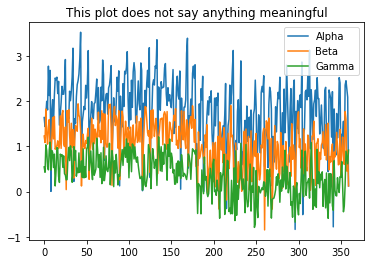

In [39]:
df[observations].plot(title="This plot does not say anything meaningful")

### Plot all combination of observation for each material

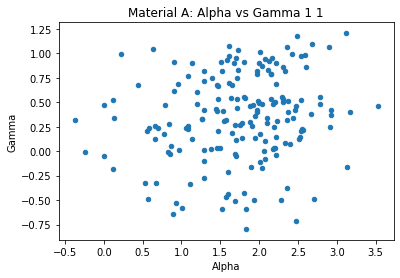

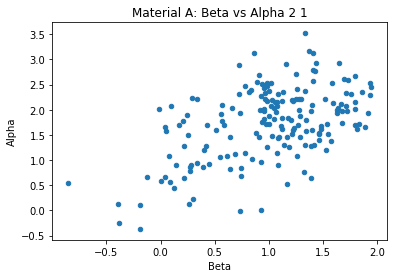

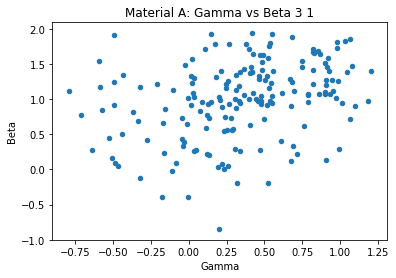

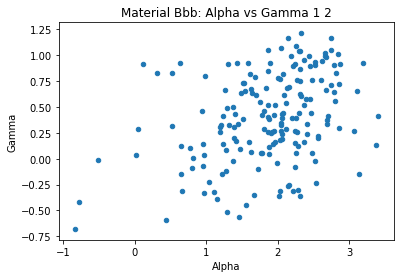

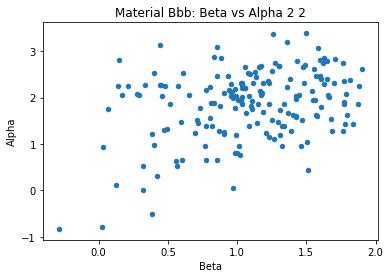

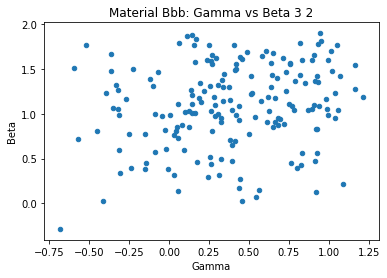

In [40]:
for j,m in enumerate(materials,1):
    for i,_ in enumerate(observations):
        title = f"Material {m}: {observations[i]} vs {observations[i-1]} {i+1} {j}"
        df[df["Material"] == m].plot(x=observations[i],y=observations[i-1],kind = "scatter",title=title)

### Rearrange the above plots with more compact visualization using matplotlib

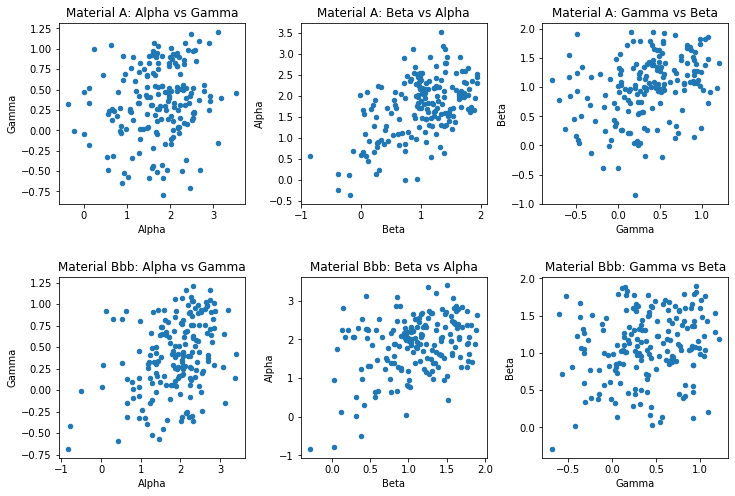

In [41]:
fig,axes = plt.subplots(2,3,figsize=(12,8))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
for j,m in enumerate(materials,1):
    for i,_ in enumerate(observations):
        title = f"Material {m}: {observations[i]} vs {observations[i-1]}"
        df[df["Material"] == m].plot(x=observations[i],y=observations[i-1],kind = "scatter",title=title,ax=axes[j-1,i])

# Wrap up

I believe 5 skills promised in the beginning have been demonstrated here. 

1. [X] Loading excel files to pandas dataframe
2. [X] Basics of slicing and other operation in pandas
3. [X] Using simple regex as pattern searching tool
4. [X] Creating a complex loops (5 layers deep)
5. [X] Quick and dirty plotting
6. [X] Python syntactic sugar such as list comprehenshion, enumerate, zip

Hopefully readers may benefit from this example.



## About the Author:

<a href="https://www.linkedin.com/in/alvin-alexander-75370943/">Alvin Alexander</a> is a marathon runner with a strong inclination for scripting & programming while working in oil & gas industry. Chemist by training, data management by trade, learner by vocation.

Also thanks to Airi for providing this original dataset for the original transformation

<hr>

Copyright &copy; 2020